# Fine-Tuning small LLM's on medical-01-resoning dataset.

In [ ]:
%%capture
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U transformers

In [ ]:
from huggingface_hub import login
import os

hf_token = os.environ.get("HF_TOKEN")
login(hf_token)

##  Quantization Configuration: This reduces the models memory footprintand potenially speeds up the inference.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_dir = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>
{}
</think>
{}"""

EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["Question"]
    complex_cots = examples["Complex_CoT"]
    outputs = examples["Response"]
    texts = []
    for question, cot, response in zip(inputs, complex_cots, outputs):
        # Append the EOS token to the response if it's not already there
        if not response.endswith(tokenizer.eos_token):
            response += tokenizer.eos_token
        text = train_prompt_style.format(question, cot, response)
        texts.append(text)
    return {"text": texts}

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "FreedomIntelligence/medical-o1-reasoning-SFT",
    "en",
    split="train[0:2000]",
    trust_remote_code=True,
)
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)
dataset["text"][10]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

"Below is an instruction that describes a task, paired with an input that provides further context. \nWrite a response that appropriately completes the request. \nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n\n### Instruction:\nYou are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. \nPlease answer the following medical question. \n\n### Question:\nIn a patient with dermatomyositis as indicated by fatigue, muscle weakness, a scaly rash, elevated creatine kinase-MB, anti-Jo-1 antibodies, and perimysial inflammation, which type of cancer is most often associated with this condition?\n\n### Response:\n<think>\nAlright, so when I'm thinking about dermatomyositis, I know it's an inflammatory condition with muscle weakness and a telltale skin rash. It's sometimes linked to certain cancers. \n\nNow, I remember reading somewhere that when you have

In [ ]:
dataset

Dataset({
    features: ['Question', 'Complex_CoT', 'Response', 'text'],
    num_rows: 2000
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>

"""

question = dataset[10]['Question']
inputs = tokenizer(
    [inference_prompt_style.format(question) + tokenizer.eos_token],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0].split("### Response:")[1])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



<think>

1. Dermatomyositis is an inflammatory myopathy characterized by muscle weakness and a characteristic rash.
2. The presence of a scaly rash, elevated creatine kinase-MB, anti-Jo-1 antibodies, and perimysial inflammation are consistent with a diagnosis of dermatomyositis.
3. While dermatomyositis is an idiopathic condition in most cases, it can also be associated with underlying malignancies.
4. The most common types of cancer associated with dermatomyositis are:
   a. Ovarian cancer in women
   b. Lung cancer in men and women
   c. Breast cancer in women
5. The exact mechanism by which cancer leads to dermatomyositis is not fully understood, but it is believed that cancer cells produce cytokines and other inflammatory mediators that contribute to muscle inflammation and weakness.

Therefore, based on the given information, the patient with dermatomyositis is most likely to have an underlying ovarian cancer (in women) or lung cancer (in men and women). However, it is important 

In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA config
peft_config = LoraConfig(
    lora_alpha=16,                           # Scaling factor for LoRA
    lora_dropout=0.05,                       # Add slight dropout for regularization
    r=64,                                    # Rank of the LoRA update matrices
    bias="none",                             # No bias reparameterization
    task_type="CAUSAL_LM",                   # Task type: Causal Language Modeling
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Target modules for LoRA
)

model = get_peft_model(model, peft_config)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments


# Training Arguments
training_arguments = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    logging_steps=0.2,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="none"
)

# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset,
    peft_config=peft_config,
    data_collator=data_collator,
)

Converting train dataset to ChatML:   0%|          | 0/2000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
model.config.use_cache = False
trainer.train()

Step,Training Loss
200,1.131700
400,1.067000
600,1.055000
800,1.051700
1000,1.026200


TrainOutput(global_step=1000, training_loss=1.0663154907226562, metrics={'train_runtime': 838.4412, 'train_samples_per_second': 2.385, 'train_steps_per_second': 1.193, 'total_flos': 7.10799611923415e+16, 'train_loss': 1.0663154907226562})

In [ ]:
question = dataset[10]['Question']
inputs = tokenizer(
    [inference_prompt_style.format(question) + tokenizer.eos_token],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0].split("### Response:")[1])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



<think>

 Alright, let's think about dermatomyositis for a second. It's a condition that involves both skin and muscle issues. The skin part is pretty noticeable with that scaly rash, and the muscle part is where it gets tricky. People with dermatomyositis often feel really tired and weak, and their muscle enzymes, like creatine kinase-MB, are usually elevated.

Now, when we talk about dermatomyositis, we can't ignore the link to cancer. It's like a classic association. But which type of cancer? Hmm, I've heard that ovarian cancer is often linked to dermatomyositis. It's like they go hand in hand.

Let's dig a bit deeper. Ovarian cancer is known for being sneaky because it doesn't always show symptoms until it's advanced. That's why it's sometimes called a 'silent killer.' It's not uncommon for people with dermatomyositis to have ovarian cancer lurking in the background.

Oh, and there's this thing called the 'Jo-1 antibody.' It's a marker that's often found in people with dermatomyos

In [ ]:
new_model_name = "Mistral-7B-Instruct-v0.2-Medical-Reasoning"
model.push_to_hub(new_model_name)
tokenizer.push_to_hub(new_model_name)

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rishi336/Mistral-7B-Instruct-v0.2-Medical-Reasoning/commit/dc6411560cc071ff6e42545248677103c429824e', commit_message='Upload tokenizer', commit_description='', oid='dc6411560cc071ff6e42545248677103c429824e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rishi336/Mistral-7B-Instruct-v0.2-Medical-Reasoning', endpoint='https://huggingface.co', repo_type='model', repo_id='rishi336/Mistral-7B-Instruct-v0.2-Medical-Reasoning'), pr_revision=None, pr_num=None)

#Evaluation

In [ ]:
%%capture
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U transformers

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

# -----------------------------
# Load Model & Tokenizer
# -----------------------------
model_id = "rishi336/Mistral-7B-Instruct-v0.2-Medical-Reasoning"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # avoid padding errors

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    trust_remote_code=True
)

model.eval()
model.config.use_cache = False



tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/867 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

In [ ]:
# -----------------------------
# Load Dataset
# -----------------------------
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", 'en', split="train[3000:3005]")  # limit for demo


In [ ]:
# -----------------------------
# Inference Function
# -----------------------------
def generate_response(question):
    inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>

"""

    inputs = tokenizer(inference_prompt_style, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=300,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded.split("### Response:")[-1].strip()

In [ ]:
# -----------------------------
# Collect Predictions & References
# -----------------------------
preds = []
refs = []

for example in dataset:
    question = example["Question"]
    reference = example["Response"]
    response = generate_response(question)
    preds.append(response)
    refs.append(reference)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=abe967db7fe45df4c6100777cac3551c13c22c04b0406f4558b3f2d5dadb8806
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


BLEU: 0.0
ROUGE-1: 0.1769581440117048
ROUGE-2: 0.021215905893783787
ROUGE-L: 0.09775495198081077


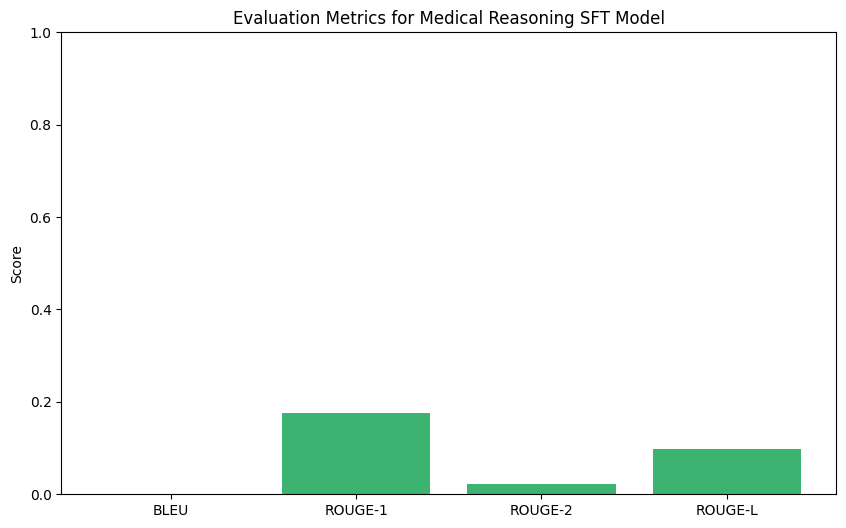

In [ ]:
# -----------------------------
# Evaluation
# -----------------------------
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

bleu_score = bleu.compute(predictions=preds, references=[[r] for r in refs])
rouge_score = rouge.compute(predictions=preds, references=refs)

print("BLEU:", bleu_score["bleu"])
print("ROUGE-1:", rouge_score["rouge1"])
print("ROUGE-2:", rouge_score["rouge2"])
print("ROUGE-L:", rouge_score["rougeL"])

# -----------------------------
# Visualization
# -----------------------------
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [
    bleu_score['bleu'],
    rouge_score['rouge1'],
    rouge_score['rouge2'],
    rouge_score['rougeL']
]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='mediumseagreen')
plt.title('Evaluation Metrics for Medical Reasoning SFT Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()